Two-Layer Fully Connected Network

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.src import ops
from keras.src.api_export import keras_export
from tensorflow.keras.optimizers import Optimizer
from keras.src.optimizers import optimizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

!git clone https://github.com/ninomiyalab/ADINA.git

def reset_random_seeds(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

Cloning into 'ADINA'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 53 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 142.61 KiB | 8.39 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, Flatten, Lambda, Resizing, AveragePooling2D
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import csv
from sklearn import datasets
from tensorflow.keras import metrics

import sys
sys.path.append('/content/ADINA')
from optimizer.adina import Adina

def compare_MNIST(i):
    np.random.seed(i)

    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()


    x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
    y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)


# Constants
RANDSEED = 200
epoch = 20
batch_sizes = [16, 32, 64, 512, 1024, 2048]
HIDDEN1 = 10
HIDDEN2 = 10
results = {}

# Data preparation
(X_train_full, y_train_full), (X_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()
X = np.vstack([X_train_full.reshape(-1, 28*28), X_test_full.reshape(-1, 28*28)])
y = np.hstack([y_train_full, y_test_full])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# No more one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDSEED
)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Keep the label as one-dimensional
y_train = y_train.reshape(-1)  # Ensure y_train is 1-dimensional
y_test = y_test.reshape(-1)    # Ensure y_test is 1-dimensional

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

def train_model(model_name, optimizer, batch_size):
    reset_random_seeds(RANDSEED)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(HIDDEN1, activation=tf.nn.relu),
        tf.keras.layers.Dense(HIDDEN2, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Fixed typo here
        metrics=['accuracy']
    )

    initial_results = model.evaluate(X_train, y_train, batch_size)
    initial_val_results = model.evaluate(X_test, y_test, batch_size)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epoch,
        validation_data=(X_test, y_test),
        verbose=1
    )

    history.history['loss'].insert(0, initial_results[0])
    history.history['accuracy'].insert(0, initial_results[1])
    history.history['val_loss'].insert(0, initial_val_results[0])
    history.history['val_accuracy'].insert(0, initial_val_results[1])

    return history

# Rest of the code remains the same
best_results = {
    'Batch Size': [],
    'Optimizer': [],
    'Best Train Loss': [],
    'Best Val Loss': [],
    'Best Train Acc': [],
    'Best Val Acc': []
}

# Training with different batch sizes
for batch_size in batch_sizes:
    print(f"\nTraining with batch size {batch_size}")
    optimizers = {
        'Adam': tf.keras.optimizers.Adam(),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, epsilon=1e-7),
        'ADINA': Adina(a=0.1, b=0.9)
    }

    batch_results = {}
    for name, optimizer in optimizers.items():
        print(f"Training {name}")
        history = train_model(name, optimizer, batch_size)

        best_loss = [history.history['loss'][0]]
        best_val_loss = [history.history['val_loss'][0]]

        for i in range(1, len(history.history['loss'])):
            best_loss.append(min(history.history['loss'][i], best_loss[-1]))
            best_val_loss.append(min(history.history['val_loss'][i], best_val_loss[-1]))

        batch_results[name] = {
            'train_loss': best_loss,
            'val_loss': best_val_loss,
            'train_acc': history.history['accuracy'],
            'val_acc': history.history['val_accuracy']
        }

        best_results['Batch Size'].append(batch_size)
        best_results['Optimizer'].append(name)
        best_results['Best Train Loss'].append(min(history.history['loss']))
        best_results['Best Val Loss'].append(min(history.history['val_loss']))
        best_results['Best Train Acc'].append(max(history.history['accuracy']))
        best_results['Best Val Acc'].append(max(history.history['val_accuracy']))

    results[batch_size] = batch_results


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training with batch size 16
Training Adam
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1139 - loss: 2.4119
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1108 - loss: 2.4208
Epoch 1/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7550 - loss: 0.7681 - val_accuracy: 0.9091 - val_loss: 0.3101
Epoch 2/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9179 - loss: 0.2957 - val_accuracy: 0.9202 - val_loss: 0.2835
Epoch 3/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9261 - loss: 0.2574 - val_accuracy: 0.9229 - val_loss: 0.2705
Epoch 4/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9324 - loss: 0.2350 - val_accuracy: 0.9255 - val_loss: 0.2708
Epoch 5/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9369 - loss: 0.2222 - val_accuracy: 0.9267 - val_loss: 0.2728
Epoch 6/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9402 - loss: 0.2097 - val_accuracy: 

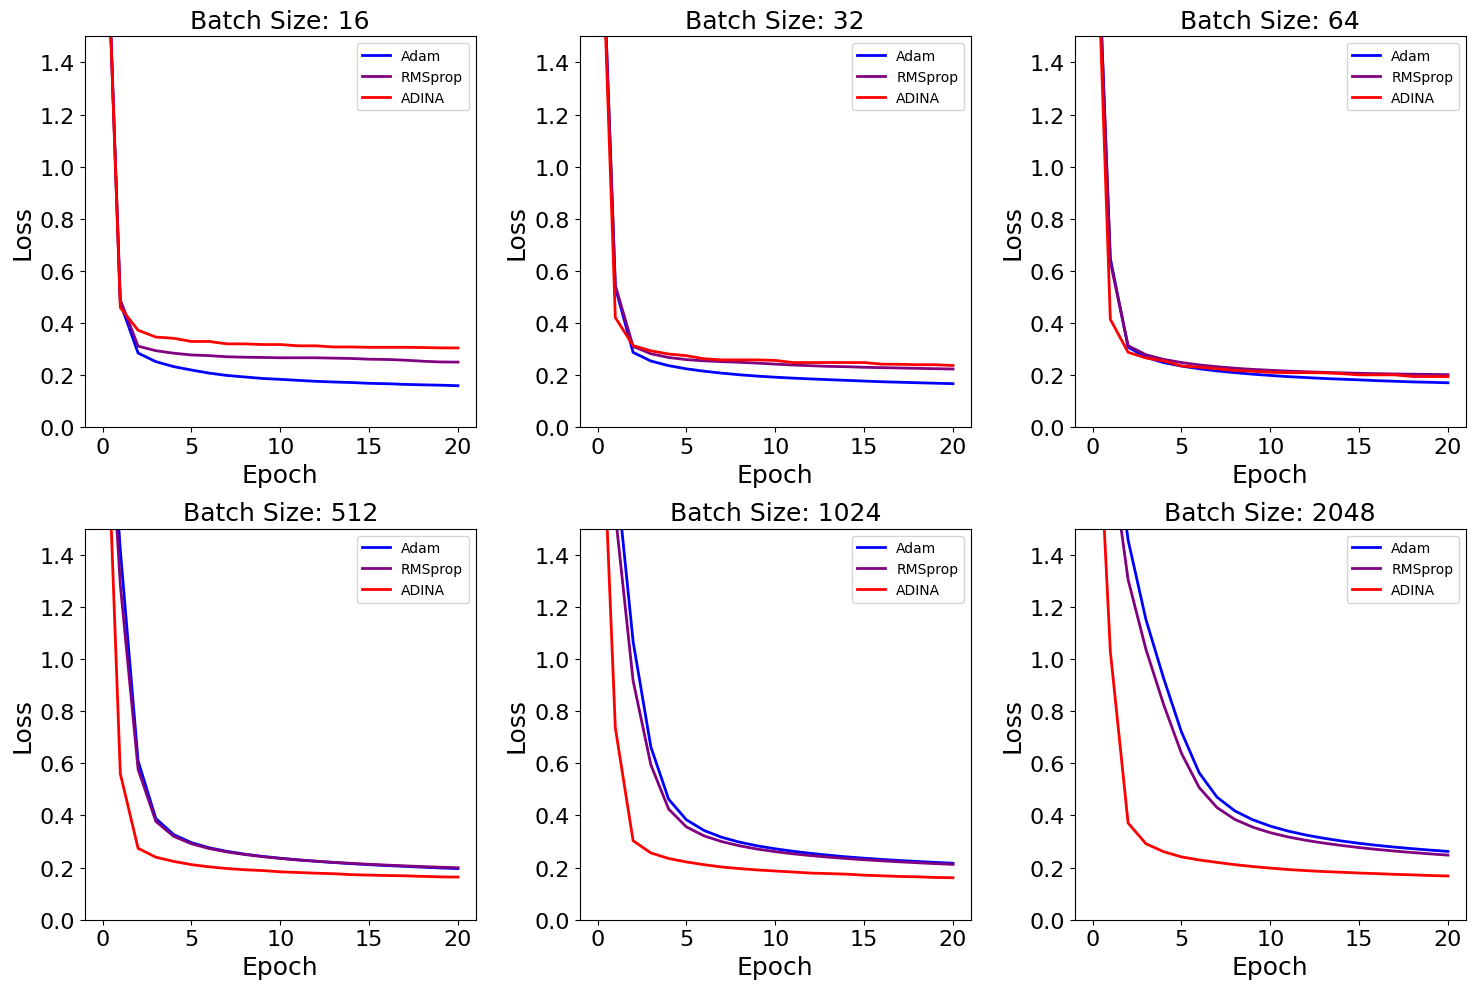

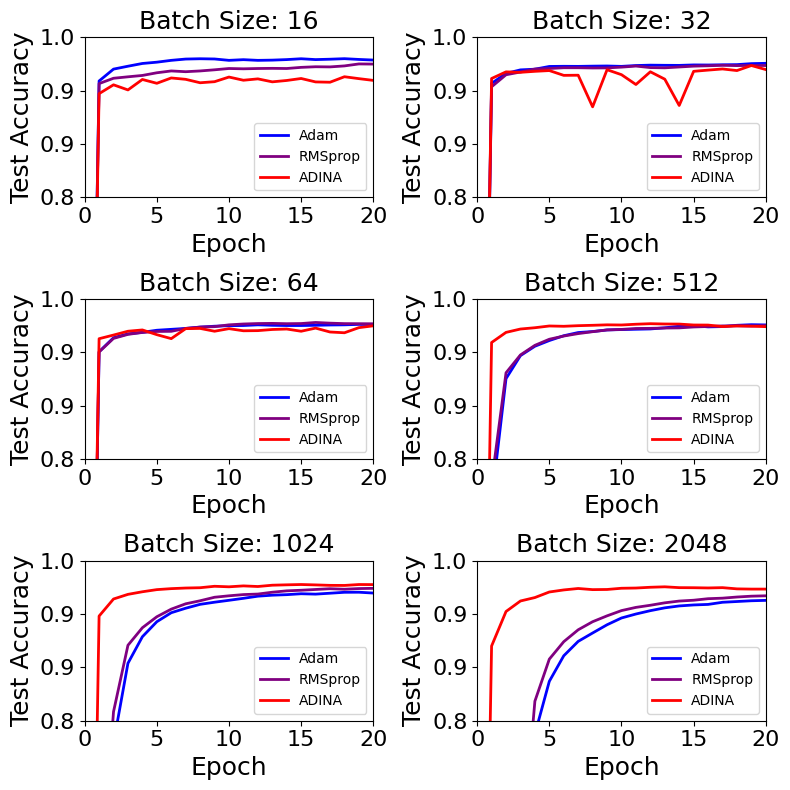

In [3]:
# Plotting
colors = {'Adam': 'blue', 'RMSprop': 'purple', 'ADINA': 'red'}
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Loss plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, batch_size in enumerate(batch_sizes):
    for name in optimizers.keys():
        axes[idx].plot(results[batch_size][name]['train_loss'],
                      color=colors[name],
                      label=f'{name}',
                      linewidth=2,
                      linestyle='-')

    axes[idx].set_title(f'Batch Size: {batch_size}', fontsize=18)
    axes[idx].set_xlabel('Epoch', fontsize=18)
    axes[idx].set_ylabel('Loss', fontsize=18)
    axes[idx].set_ylim(0, 1.5)
    axes[idx].legend()

plt.tight_layout()
plt.show()
plt.close()

# Accuracy plots
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
axes = axes.ravel()

for idx, batch_size in enumerate(batch_sizes):
    for name in optimizers.keys():

        axes[idx].plot(results[batch_size][name]['val_acc'],
                      color=colors[name],
                      label=f'{name}',
                      linewidth=2,
                      linestyle='-')
    axes[idx].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axes[idx].set_title(f'Batch Size: {batch_size}', fontsize=18)
    axes[idx].set_xlabel('Epoch', fontsize=18)
    axes[idx].set_ylabel('Test Accuracy', fontsize=18)
    axes[idx].set_ylim(0.8, 0.95)
    axes[idx].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}'))
    axes[idx].set_xlim(0, 20)
    axes[idx].legend()

plt.tight_layout()
plt.show()
plt.close()

Simple CNN

Training with ADINA...
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7158 - loss: 0.8267 - val_accuracy: 0.9814 - val_loss: 0.0589
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9600 - loss: 0.1311 - val_accuracy: 0.9868 - val_loss: 0.0388
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9710 - loss: 0.0987 - val_accuracy: 0.9887 - val_loss: 0.0370
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9745 - loss: 0.0855 - val_accuracy: 0.9894 - val_loss: 0.0315
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9773 - loss: 0.0762 - val_accuracy: 0.9890 - val_loss: 0.0318
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9773 - loss: 0.0714 - val_accuracy: 0.9889 - val_loss: 0.0321
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9793 - loss: 0.0673 - val_accuracy: 0.9901 - val_loss: 0.0278
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9808 - loss: 0.0642 - v

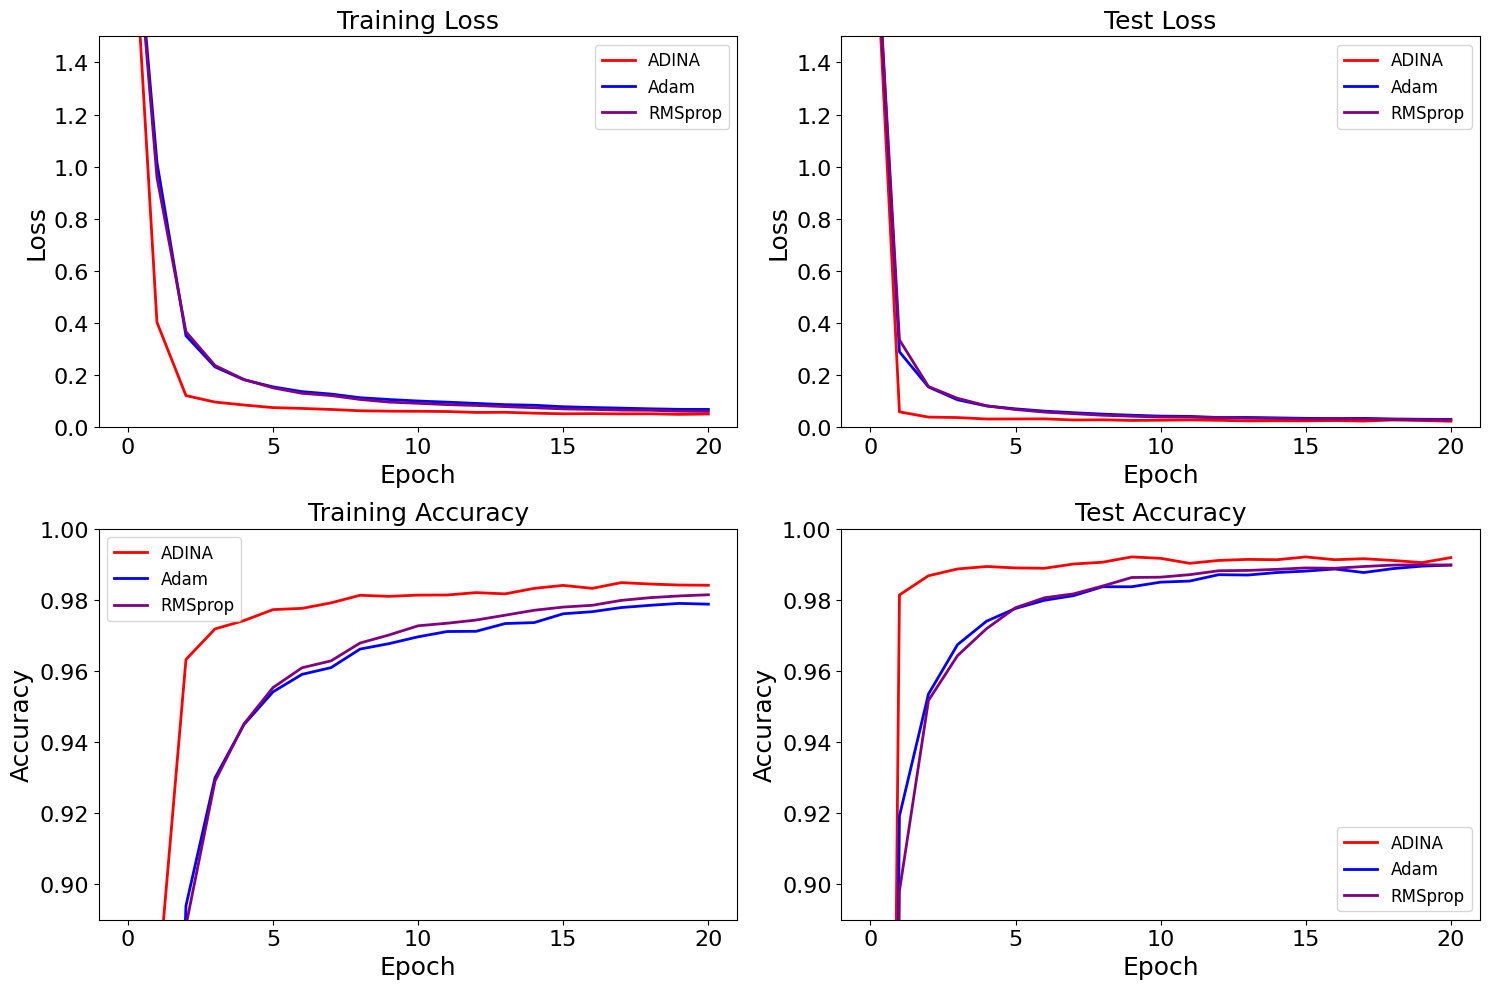

In [4]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
sys.path.append('/content/ADINA')
from optimizer.adina import Adina

# Constants
RANDSEED = 200
MINIBATCH = 1024
EPOCHS = 20
HIDDEN1 = 10
HIDDEN2 = 10

def train_model(optimizer, x_train, y_train, x_test, y_test):
    reset_random_seeds(RANDSEED)
    base_model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        # First Conv Block
        layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Conv Block
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    base_model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Initial state evaluation
    initial_results = base_model.evaluate(x_train, y_train, verbose=0)
    initial_val_results = base_model.evaluate(x_test, y_test, verbose=0)

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(MINIBATCH)

    try:
        history = base_model.fit(
            x_train, y_train,
            epochs=EPOCHS,
            batch_size=MINIBATCH,
            validation_data=(x_test, y_test)
        )

        # Append the initial value to the history
        history.history['loss'].insert(0, initial_results[0])
        history.history['accuracy'].insert(0, initial_results[1])
        history.history['val_loss'].insert(0, initial_val_results[0])
        history.history['val_accuracy'].insert(0, initial_val_results[1])
        return history

    except Exception as e:
        print(f"Training failed: {str(e)}")
        if 'model' in locals():
            tf.keras.backend.clear_session()
            #del model
            del base_model
        return None

def plot_results(histories, colors, save_path=None):
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    axes = [ax1, ax2, ax3, ax4]
    metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    titles = ['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy']

    for ax, metric, title in zip(axes, metrics, titles):
        for name, history in histories.items():
            if history is not None:
                ax.plot(history.history[metric],
                       color=colors[name],
                       label=name,
                       linewidth=2)
        if 'loss' in metric:
            ax.set_ylim(0, 1.5)
        if 'accuracy' in metric:
            ax.set_ylim(0.89, 1.0)
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        if 'val_loss' in metric:
            ax.set_ylim(0, 1.5)
        if 'val_accuracy' in metric:
            ax.set_ylim(0.89, 1.0)
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        ax.set_title(title, fontsize=18)
        ax.set_xlabel('Epoch', fontsize=18)
        ax.set_ylabel(title.split()[-1], fontsize=18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.tick_params(labelsize=16)
        ax.legend(fontsize=12)
        ax.grid(False)

    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define optimizers
    optimizers = {
        'ADINA': Adina(a=0.1, b=0.9),
        'Adam': tf.keras.optimizers.Adam(),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, epsilon=1e-7)
    }

    # Train models
    histories = {}
    for name, optimizer in optimizers.items():
        print(f"Training with {name}...")
        histories[name] = train_model(optimizer, x_train, y_train, x_test, y_test)

    # Plot results
    colors = {
        'ADINA': 'red',
        'Adam': 'blue',
        'RMSprop': 'purple',
    }

    plot_results(histories, colors)

if __name__ == "__main__":
    main()